# Figure 1

### Load functions and packages

In [19]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
import seaborn as sns

import regionmask

import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)


def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/', dpi=200, ext='png', **kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
        
    else:
        print('File already exists, rename or delete.')

In [3]:
def convert_ipcc_to_latlon(
    data: xr.DataArray,
    mask: regionmask.Regions = regionmask.defined_regions.ar6.all,
):

    mean_data   = data.sel(metric='mean')
    strict_data = data.sel(metric='strict')
    delay_data  = data.sel(metric='delay')
    delay_mask  = data.sel(metric='delay_mask')

    unc_mask = mask.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

    _mean_mask   = unc_mask.copy()
    _strict_mask = unc_mask.copy()
    _delay_data_mask  = unc_mask.copy()
    _delay_mask_mask  = unc_mask.copy()

    del unc_mask

    offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
    for i in mask.numbers:
        
        _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
        _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
        _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
        _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

    regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset
    
    return regional_masked_da

## Load computed ToE data

In [4]:
toe_savedir = "../data/"

spatial_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.5x5.nc")
regional_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

all_spatial_da = xr.open_dataarray(f"{toe_savedir}/all_ToE.5x5.nc")
all_regional_da = xr.open_dataarray(f"{toe_savedir}/all_ToE.IPCCRegions.nc")

Process the all combinations data.

In [5]:
all_spatial_obs_da = all_spatial_da.drop_sel(obs="DCENT_unfilled")

strict_spatial_toe = all_spatial_obs_da.where(~np.isnan(all_spatial_obs_da),np.inf).quantile(q=0.95, dim=['realization', "model", "obs"], method='nearest')
strict_spatial_toe = strict_spatial_toe.where(~np.isinf(strict_spatial_toe),np.nan).drop_vars("quantile")

mean_spatial_toe = all_spatial_obs_da.where(~np.isnan(all_spatial_obs_da),np.inf).quantile(q=0.5, dim=['realization', "model", "obs"], method='nearest')
mean_spatial_toe = mean_spatial_toe.where(~np.isinf(mean_spatial_toe),np.nan).drop_vars("quantile")

# Compute the delay and conditional delay mask:
delay_toe = strict_spatial_toe - mean_spatial_toe # Compute the delay
delay_undef_region = np.bitwise_and(np.isnan(strict_spatial_toe), ~np.isnan(mean_spatial_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
delay_toe = xr.where(delay_undef_region, 2020 - mean_spatial_toe, delay_toe) # Apply the conditional mask

all_spatial_toes = xr.concat(
    [mean_spatial_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
    strict_spatial_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
    delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
    delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
    ],
    dim='metric',
)

all_spatial_toes = all_spatial_toes.assign_coords({'obs':'all', "model":"all"}).expand_dims(['obs',"model"])

In [6]:
all_regional_obs_da = all_regional_da.drop_sel(obs="DCENT_unfilled")

strict_regional_toe = all_regional_obs_da.where(~np.isnan(all_regional_obs_da), np.inf).quantile(q=0.95, dim=['realization', "model", "obs"], method='nearest')
strict_regional_toe = strict_regional_toe.where(~np.isinf(strict_regional_toe), np.nan).drop_vars("quantile")

mean_regional_toe = all_regional_obs_da.where(~np.isnan(all_regional_obs_da), np.inf).quantile(q=0.5, dim=['realization', "model", "obs"], method='nearest')
mean_regional_toe = mean_regional_toe.where(~np.isinf(mean_regional_toe), np.nan).drop_vars("quantile")

# Compute the delay and conditional delay mask:
delay_toe = strict_regional_toe - mean_regional_toe # Compute the delay
delay_undef_region = np.bitwise_and(np.isnan(strict_regional_toe), ~np.isnan(mean_regional_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
delay_toe = xr.where(delay_undef_region, 2020 - mean_regional_toe, delay_toe) # Apply the conditional mask

all_regional_toes = xr.concat(
    [mean_regional_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
    strict_regional_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
    delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
    delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
    ],
    dim='metric',
)

all_regional_toes = all_regional_toes.assign_coords({'obs':'all', "model":"all"}).expand_dims(['obs',"model"])

# Plot with IPCC Regions

In [7]:
# Make a better land mask for the spatial 5x5 deg. regions
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask_3D_frac_approx(
    spatial_masked_da
).squeeze()
spatial_landmask = land>0.5

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [8]:
# Create a landmaks for the IPCC regions.
mask = regionmask.defined_regions.ar6.land
regional_latlon_da = convert_ipcc_to_latlon(
    regional_masked_da,
    mask=mask,
)

# Do for all of the data
regional_latlon_all_da = convert_ipcc_to_latlon(
    all_regional_toes,
    mask=mask,
)

landmask = ~np.isnan(mask.mask(regional_latlon_da["lon"], regional_latlon_da["lat"],))

In [9]:
# Mask the spatial ToE data with DCENT availability
spatial_landmasked_da = spatial_masked_da.where(landmask)

In [10]:
# Function for the regional figures.
def plot_regional_toe_and_delay(
    data,
    obs,
    model,
    toe_levels=np.linspace(1960,2020,13),
    delay_levels=list(np.linspace(0,20,5)),
    title=True,
    surfacemask=None,
    surfacehatch="o",
):
    
    data_subset     = data.sel(obs=obs,model=model)
    data_mean       = data_subset.sel(metric='mean')
    data_strict     = data_subset.sel(metric='strict')
    data_delay      = data_subset.sel(metric='delay')
    data_delay_mask = data_subset.sel(metric='delay_mask')

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(14,4))
    axs = axs.flat

    cax1 = plt.axes([0.18, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    ToE_cmap.set_over('white')
    
    delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
    delay_cmap.set_over('magenta')
    
    masks  = [data_mean,data_strict,data_delay]
    titles = ['Median ToE','Strict ToE','Observational delay']
    levels = [toe_levels,toe_levels,delay_levels]
    cmaps  = [ToE_cmap,ToE_cmap,delay_cmap]
    extend = ['max','max','max']

    plt.subplots_adjust(wspace=0.05)

    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):

        im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                          transform=ccrs.PlateCarree(),
                          levels=_levels,
                          cmap=_cmap,
                          extend=_extend,
                         )

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    _ = axs[2].contourf(data_delay_mask.lon,data_delay_mask.lat,data_delay_mask, levels=[0,0.5,2], colors='none',
                        transform=ccrs.PlateCarree(),
                        hatches=[None,'\\\\',],
                        extend='max',
                       )

    grey = axs[2].contourf(data_delay.lon,data_delay.lat,np.isnan(data_delay),
                           transform=ccrs.PlateCarree(),
                           extend='max',
                           colors=['none','gray'],
                           levels=[0,0.5,1.5],
                          )

    for _ax in axs:
        if surfacemask is not None:
            _ = _ax.contourf(
                surfacemask.lon,
                surfacemask.lat,
                ~surfacemask,
                levels=[0,0.5,2],
                colors='none',
                transform=ccrs.PlateCarree(),
                hatches=[None, surfacehatch,],
                extend='max',
           )

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=toe_levels,
                         cax=cax1,
                        )

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels, 
                         cax=cax2,
                        )

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)
    
    fig.text(0.14, 0.68, "a.", fontsize=14)
    fig.text(0.40, 0.68, "b.", fontsize=14)
    fig.text(0.665, 0.68, "c.", fontsize=14)
    
    if title:
        fig.suptitle('IPCC Region Emergence: %s-%s' % (model,obs),fontsize=20,y=0.88)
    
    return fig

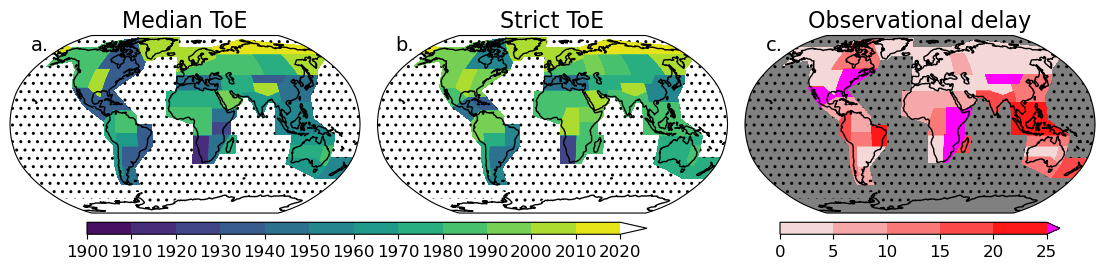

In [18]:
out_fig = plot_regional_toe_and_delay(
    regional_latlon_da,
    obs='GISTEMP_5x5',
    model='CESM1',
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
    surfacemask=landmask,
    surfacehatch="..",
    title=False,
)

to_png(
    file=out_fig,
    filename='landonly_ToE_regionalmap_1900start_%s_%s' % ("GISTEMP", "CESM1"),
    loc="../figures/",
    dpi=300,
    ext='pdf',
    bbox_inches='tight',
)

### Plot with Spatial Data

In [20]:
def plot_spatial_toe_and_delay(
    data,
    obs,
    model,
    toe_levels=np.linspace(1960,2020,13),
    delay_levels=list(np.linspace(0,20,5)),
    title=True,
    surfacemask=None,
    surfacehatch="o",
):

    data_subset = data.sel(obs=obs,model=model)
    mean_data   = data_subset.sel(metric='mean')
    strict_data = data_subset.sel(metric='strict')
    delay_data  = data_subset.sel(metric='delay')
    delay_mask  = data_subset.sel(metric='delay_mask')

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(14, 4))
    axs = axs.flat

    cax1 = plt.axes([0.175, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.685, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    ToE_cmap.set_over('white')
    
    delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
    delay_cmap.set_over('magenta')
    delay_cmap.colorbar_extend = True

    masks  = [mean_data,strict_data,delay_data]
    titles = ['Median ToE','Strict ToE','Observational delay']
    levels = [toe_levels,toe_levels,delay_levels] 
    cmaps = [ToE_cmap,ToE_cmap,delay_cmap]

    plt.subplots_adjust(wspace=0.05)
    
    ims = [] 
    for _ax,_mask,_label,_levels,_cmap in zip(axs,masks,titles,levels,cmaps):

        _norm = BoundaryNorm(_levels, ncolors=_cmap.N, clip=False)

        im = _ax.pcolormesh(_mask.lon,_mask.lat,_mask,
                           transform=ccrs.PlateCarree(),
                           cmap=_cmap,
                           norm=_norm, 
                           )

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    _ = axs[2].contourf(delay_mask.lon,delay_mask.lat,delay_mask, levels=[0,0.5,2], colors='none',
                        transform=ccrs.PlateCarree(),
                        hatches=[None,'\\\\',],
                        extend='max',
                       )

    grey = axs[2].contourf(mean_data.lon,mean_data.lat,np.isnan(mean_data),
                           transform=ccrs.PlateCarree(),
                           extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                          )

    for _ax in axs:
        if surfacemask is not None:
            _ = _ax.contourf(
                surfacemask.lon,
                surfacemask.lat,
                ~surfacemask,
                levels=[0,0.5,2],
                colors='none',
                transform=ccrs.PlateCarree(),
                hatches=[None, surfacehatch,],
                extend='max',
           )
    
    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=toe_levels,
                         cax=cax1,
                         extend='max',
                        )

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels, # delay_levels, 
                         cax=cax2,
                         extend='max',
                        )

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)

    fig.text(0.14, 0.68, "d.", fontsize=14)
    fig.text(0.40, 0.68, "e.", fontsize=14)
    fig.text(0.665, 0.68, "f.", fontsize=14)

    if title:
        fig.suptitle('5x5 Emergence: %s-%s' % (model,obs),fontsize=20,y=0.88)    

    return fig

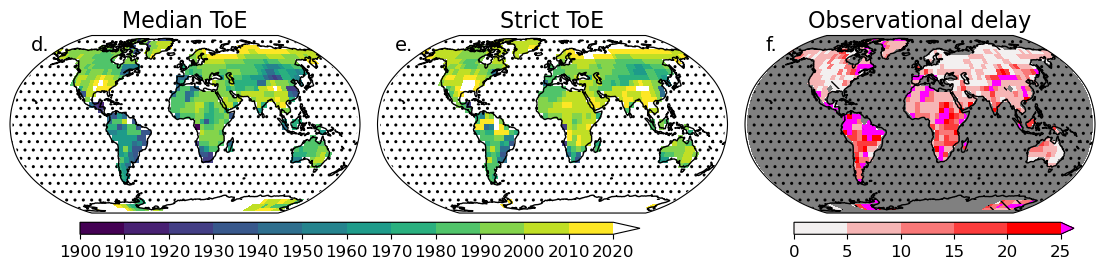

In [22]:
# User set-up
data  = spatial_landmasked_da.where(spatial_landmask)
obs = 'GISTEMP_5x5' # HadCRUT
model = 'CESM1'

out_fig = plot_spatial_toe_and_delay(
    data=data,
    obs=obs,
    model=model,
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
    surfacemask=spatial_landmask,
    surfacehatch="..",
    title=False,
)

to_png(
    file=out_fig,
    filename='landonly_ToE_spatialmap_%s_%s' % ("GISTEMP", "CESM1"),
    loc="../figures/",
    dpi=300,
    ext='pdf',
    bbox_inches='tight',
)